In [1]:
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime, timedelta
import sys
from scipy.stats import linregress

In [2]:
from config_account_reader import ConfigAccountReader
config_accout_reader = ConfigAccountReader('config_account.yaml')
exchange_name = config_accout_reader.get_exchange_name()
symbol = config_accout_reader.get_market_symbol()
public_key = config_accout_reader.get_public_key()
secret = config_accout_reader.get_secret_key()

# I need the exchange 

#### https://docs.ccxt.com/en/latest/manual.html#configuring-api-keys

In [3]:
# from variable id
exchange_id = exchange_name
exchange_class = getattr(ccxt, exchange_id)
exchange = exchange_class({
    'apiKey': public_key,
    'secret': secret,
})

In [4]:
from config_strategy_reader import ConfigStrategyReader
config_strategy_reader = ConfigStrategyReader('config_strategy.yaml')

position_size = config_strategy_reader.get_position_size()
check_orders_frequency = config_strategy_reader.get_check_orders_frequency()
closed_order_status = config_strategy_reader.get_closed_order_status()

num_buy_grid_lines = config_strategy_reader.get_num_buy_grid_lines()
num_sell_grid_lines = config_strategy_reader.get_num_sell_grid_lines()
grid_size = config_strategy_reader.get_grid_size()

In [5]:
markets = exchange.load_markets()
symbols = [item for item in markets if item.endswith('USDT')]
print(f'Amount of pair of market: {len(symbols)}')

Amount of pair of market: 414


#### time stamps for period of time back

In [6]:
weeks = 4
now = datetime.now()
back = now - timedelta(weeks=weeks)
back_timestamp = int(back.timestamp()*1000)
print(f'now: {now} minus weeks: {weeks} is back time: {back}\nback timestamp is {back_timestamp}')

now: 2022-11-30 10:20:11.455843 minus weeks: 4 is back time: 2022-11-02 10:20:11.455843
back timestamp is 1667380811455


### How to get all ohlcv for pair

In [7]:
def get_all_ohlcv_for_pair(for_pair, since):
    all_ohlcv = []
    
    ohlcv = exchange.fetch_ohlcv(for_pair, '1h', since=since, limit=1000)
    all_ohlcv.extend(ohlcv)
    
    while(len(ohlcv)==1000):
        since_time_stamp = ohlcv[-1][0]
        ohlcv = exchange.fetch_ohlcv(symbol, '1h', since=since_time_stamp, limit=1000)
        all_ohlcv.extend(ohlcv)
        
    return all_ohlcv

In [8]:
def make_data_frame(ohlcv):
    df = pd.DataFrame(ohlcv)
    df.columns = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume']
    df.set_index('Time', inplace=True)
    df.index = pd.to_datetime(df.index, unit='ms')
    df = df.astype(float)
    
    return df

In [9]:
def get_slope_intercept_std_err(df):
    
    slope, intercept, r_value, p_value, std_err = linregress(x=df['Number'], y=df['Close'])
    print(f'slope: {slope},\n'
          f'intercept: {intercept},\n'
          f'r_value: {r_value},\n'
          f'p_value: {p_value},\n'
          f'std_err: {std_err}')
    df['Closetrend'] = slope * df['Number'] + intercept
    
    return slope, intercept, std_err
    

# The main loop

In [10]:
markets_parameters = []

for symbol in symbols:
    print('Exchange and the pair')
    print(f'Exchange: {exchange.name} and pair {symbol}')
    print('get all ohlcv since set time')
    ohlcv = get_all_ohlcv_for_pair(symbol, back_timestamp)
    if len(ohlcv) == 0:
        print('There is no quotation')
        continue
    
#     print('make df for ohlcv')
    df = make_data_frame(ohlcv)
    df['Number'] = np.arange(df.shape[0]) + 1
    print(df)
    
    slope, intercept, std_err = get_slope_intercept_std_err(df)    
    df['Closetrend'] = slope * df['Number'] + intercept
    
    row = [symbol, slope, intercept, std_err]
    markets_parameters.append(row)

Exchange and the pair
Exchange: Binance and pair BTC/USDT
get all ohlcv since set time
                         Open      High       Low     Close       Volume  \
Time                                                                       
2022-11-02 10:00:00  20468.06  20472.82  20339.99  20409.77  13846.64268   
2022-11-02 11:00:00  20409.77  20466.24  20407.85  20431.33   8323.13939   
2022-11-02 12:00:00  20432.38  20447.99  20360.00  20396.49  12514.14385   
2022-11-02 13:00:00  20395.82  20424.97  20361.86  20398.99  15134.16367   
2022-11-02 14:00:00  20398.99  20457.29  20393.42  20432.44  13326.51305   
...                       ...       ...       ...       ...          ...   
2022-11-30 05:00:00  16879.53  16914.58  16861.39  16864.10   8355.99700   
2022-11-30 06:00:00  16863.45  16870.77  16830.38  16860.61   8424.53584   
2022-11-30 07:00:00  16860.61  16920.16  16858.90  16884.18   8956.14794   
2022-11-30 08:00:00  16883.87  16930.66  16874.02  16890.65   7960.12284   
2

                       Open    High     Low   Close      Volume  Number
Time                                                                   
2022-11-02 10:00:00  0.4545  0.4545  0.4512  0.4533  12498514.0       1
2022-11-02 11:00:00  0.4532  0.4551  0.4531  0.4544   6349249.0       2
2022-11-02 12:00:00  0.4543  0.4562  0.4522  0.4552  11096245.0       3
2022-11-02 13:00:00  0.4553  0.4564  0.4537  0.4552   8220222.0       4
2022-11-02 14:00:00  0.4551  0.4578  0.4547  0.4569   7310085.0       5
...                     ...     ...     ...     ...         ...     ...
2022-11-30 05:00:00  0.4021  0.4023  0.4003  0.4016  11547682.0     668
2022-11-30 06:00:00  0.4015  0.4032  0.4008  0.4022   8649103.0     669
2022-11-30 07:00:00  0.4022  0.4042  0.4020  0.4039   9371987.0     670
2022-11-30 08:00:00  0.4038  0.4043  0.4012  0.4024  10364060.0     671
2022-11-30 09:00:00  0.4023  0.4031  0.4015  0.4015   3607751.0     672

[672 rows x 6 columns]
slope: -0.00011948185802578297,
intercep

                       Open    High     Low   Close     Volume  Number
Time                                                                  
2022-11-02 10:00:00  0.2226  0.2236  0.2211  0.2234   337320.7       1
2022-11-02 11:00:00  0.2235  0.2242  0.2233  0.2235   178342.5       2
2022-11-02 12:00:00  0.2234  0.2236  0.2208  0.2209   505776.6       3
2022-11-02 13:00:00  0.2208  0.2222  0.2200  0.2208   271952.3       4
2022-11-02 14:00:00  0.2209  0.2221  0.2208  0.2214   199067.3       5
...                     ...     ...     ...     ...        ...     ...
2022-11-30 05:00:00  0.2136  0.2249  0.2122  0.2189  5403958.6     668
2022-11-30 06:00:00  0.2186  0.2201  0.2100  0.2146  3430140.1     669
2022-11-30 07:00:00  0.2148  0.2249  0.2144  0.2158  4610901.0     670
2022-11-30 08:00:00  0.2158  0.2164  0.2111  0.2154  2977349.7     671
2022-11-30 09:00:00  0.2154  0.2188  0.2150  0.2166   866370.8     672

[672 rows x 6 columns]
slope: -9.198545726920634e-05,
intercept: 0.208905636

                         Open      High       Low     Close       Volume  \
Time                                                                       
2022-11-02 10:00:00  0.001979  0.001989  0.001953  0.001988  150927735.0   
2022-11-02 11:00:00  0.001988  0.001994  0.001982  0.001985   42931908.0   
2022-11-02 12:00:00  0.001985  0.001990  0.001972  0.001975   82089509.0   
2022-11-02 13:00:00  0.001975  0.001992  0.001973  0.001987   60857687.0   
2022-11-02 14:00:00  0.001987  0.002002  0.001982  0.001992   47635652.0   
...                       ...       ...       ...       ...          ...   
2022-11-30 05:00:00  0.001633  0.001650  0.001630  0.001647   47476856.0   
2022-11-30 06:00:00  0.001647  0.001649  0.001643  0.001645   32063508.0   
2022-11-30 07:00:00  0.001645  0.001650  0.001643  0.001649   24982675.0   
2022-11-30 08:00:00  0.001649  0.001660  0.001645  0.001650   50504384.0   
2022-11-30 09:00:00  0.001650  0.001653  0.001646  0.001646   16957908.0   

           

                        Open     High      Low    Close      Volume  Number
Time                                                                       
2022-11-02 10:00:00  0.01108  0.01113  0.01099  0.01112  20565672.0       1
2022-11-02 11:00:00  0.01112  0.01114  0.01112  0.01112    824601.0       2
2022-11-02 12:00:00  0.01112  0.01112  0.01106  0.01106   3293048.0       3
2022-11-02 13:00:00  0.01106  0.01110  0.01101  0.01105   5579302.0       4
2022-11-02 14:00:00  0.01105  0.01114  0.01103  0.01110   4691791.0       5
...                      ...      ...      ...      ...         ...     ...
2022-11-30 05:00:00  0.00857  0.00860  0.00857  0.00858   1320336.0     668
2022-11-30 06:00:00  0.00858  0.00858  0.00852  0.00854   5725638.0     669
2022-11-30 07:00:00  0.00855  0.00859  0.00855  0.00858   1591878.0     670
2022-11-30 08:00:00  0.00858  0.00859  0.00849  0.00855  16619384.0     671
2022-11-30 09:00:00  0.00855  0.00855  0.00853  0.00855    628580.0     672

[672 rows x

                       Open    High     Low   Close     Volume  Number
Time                                                                  
2022-11-02 10:00:00  0.8509  0.8521  0.8448  0.8513  3717059.2       1
2022-11-02 11:00:00  0.8511  0.8557  0.8510  0.8548  1713958.7       2
2022-11-02 12:00:00  0.8548  0.8561  0.8480  0.8488  2280683.1       3
2022-11-02 13:00:00  0.8488  0.8566  0.8480  0.8523  4685398.8       4
2022-11-02 14:00:00  0.8523  0.8604  0.8500  0.8569  4908320.9       5
...                     ...     ...     ...     ...        ...     ...
2022-11-30 05:00:00  0.8675  0.8679  0.8637  0.8655  1308847.8     668
2022-11-30 06:00:00  0.8654  0.8711  0.8640  0.8704  3379949.2     669
2022-11-30 07:00:00  0.8705  0.8728  0.8694  0.8705  1363621.6     670
2022-11-30 08:00:00  0.8705  0.8775  0.8687  0.8692  2337748.1     671
2022-11-30 09:00:00  0.8693  0.8713  0.8683  0.8690   291515.4     672

[672 rows x 6 columns]
slope: -0.0004720299855492472,
intercept: 1.097279310

There is no quotation
Exchange and the pair
Exchange: Binance and pair DOGE/USDT
get all ohlcv since set time
                        Open     High      Low    Close       Volume  Number
Time                                                                        
2022-11-02 10:00:00  0.13073  0.13251  0.12800  0.13168  362225566.0       1
2022-11-02 11:00:00  0.13165  0.13285  0.13053  0.13163  150586017.0       2
2022-11-02 12:00:00  0.13163  0.13174  0.12705  0.12861  264977359.0       3
2022-11-02 13:00:00  0.12861  0.13093  0.12811  0.12991  158140635.0       4
2022-11-02 14:00:00  0.12992  0.13260  0.12974  0.13153  196329363.0       5
...                      ...      ...      ...      ...          ...     ...
2022-11-30 05:00:00  0.10683  0.10684  0.10546  0.10649   54982050.0     668
2022-11-30 06:00:00  0.10650  0.10681  0.10516  0.10584   70347167.0     669
2022-11-30 07:00:00  0.10583  0.10650  0.10554  0.10622   44725460.0     670
2022-11-30 08:00:00  0.10622  0.10726  0.10

                       Open    High     Low   Close    Volume  Number
Time                                                                 
2022-11-02 10:00:00  0.4142  0.4152  0.4104  0.4147   31768.6       1
2022-11-02 11:00:00  0.4147  0.4159  0.4141  0.4143    7703.3       2
2022-11-02 12:00:00  0.4143  0.4148  0.4117  0.4124   24330.0       3
2022-11-02 13:00:00  0.4116  0.4142  0.4100  0.4128   36687.8       4
2022-11-02 14:00:00  0.4123  0.4157  0.4123  0.4141   10750.9       5
...                     ...     ...     ...     ...       ...     ...
2022-11-30 05:00:00  0.3220  0.3225  0.3218  0.3223   11446.2     668
2022-11-30 06:00:00  0.3227  0.3232  0.3223  0.3226   16722.7     669
2022-11-30 07:00:00  0.3223  0.3242  0.3220  0.3242   20453.7     670
2022-11-30 08:00:00  0.3242  0.3262  0.3238  0.3244   32184.2     671
2022-11-30 09:00:00  0.3244  0.3390  0.3244  0.3377  983206.8     672

[672 rows x 6 columns]
slope: -0.0002201874038501386,
intercept: 0.411320888776524,
r_val

                       Open    High     Low   Close     Volume  Number
Time                                                                  
2022-11-02 10:00:00  0.1779  0.1779  0.1762  0.1770    84351.0       1
2022-11-02 11:00:00  0.1770  0.1775  0.1768  0.1769     9787.0       2
2022-11-02 12:00:00  0.1770  0.1776  0.1763  0.1770    11653.0       3
2022-11-02 13:00:00  0.1770  0.1774  0.1763  0.1765     9163.0       4
2022-11-02 14:00:00  0.1766  0.1777  0.1766  0.1772    13642.0       5
...                     ...     ...     ...     ...        ...     ...
2022-11-30 05:00:00  0.2154  0.2592  0.2124  0.2519  8705351.0     668
2022-11-30 06:00:00  0.2519  0.2575  0.2286  0.2304  7478934.0     669
2022-11-30 07:00:00  0.2310  0.2312  0.2171  0.2235  3172174.0     670
2022-11-30 08:00:00  0.2236  0.2387  0.2228  0.2350  4189387.0     671
2022-11-30 09:00:00  0.2355  0.2369  0.2294  0.2320   738130.0     672

[672 rows x 6 columns]
slope: -3.8133659814474856e-05,
intercept: 0.16931084

                      Open   High    Low  Close    Volume  Number
Time                                                             
2022-11-02 10:00:00  1.389  1.396  1.378  1.396  143503.9       1
2022-11-02 11:00:00  1.396  1.399  1.391  1.392   72057.7       2
2022-11-02 12:00:00  1.392  1.393  1.383  1.385  117253.5       3
2022-11-02 13:00:00  1.385  1.392  1.379  1.385  129129.6       4
2022-11-02 14:00:00  1.385  1.396  1.381  1.389   67629.2       5
...                    ...    ...    ...    ...       ...     ...
2022-11-30 05:00:00  1.006  1.010  1.006  1.009   43399.8     668
2022-11-30 06:00:00  1.008  1.009  1.005  1.006   63272.2     669
2022-11-30 07:00:00  1.006  1.006  1.004  1.004   84209.1     670
2022-11-30 08:00:00  1.005  1.005  1.000  1.002  136707.7     671
2022-11-30 09:00:00  1.001  1.004  1.001  1.001   47237.6     672

[672 rows x 6 columns]
slope: -0.0007103152568694063,
intercept: 1.3349511434603647,
r_value: -0.8154294642362003,
p_value: 3.158757317816471

                        Open     High      Low    Close     Volume  Number
Time                                                                      
2022-11-02 10:00:00  0.03358  0.03377  0.03339  0.03377  2377768.4       1
2022-11-02 11:00:00  0.03375  0.03379  0.03366  0.03370   158063.2       2
2022-11-02 12:00:00  0.03369  0.03375  0.03345  0.03358  1249745.1       3
2022-11-02 13:00:00  0.03357  0.03377  0.03345  0.03360  1736840.7       4
2022-11-02 14:00:00  0.03359  0.03390  0.03355  0.03373  1428578.2       5
...                      ...      ...      ...      ...        ...     ...
2022-11-30 05:00:00  0.02885  0.02885  0.02846  0.02855  1248391.5     668
2022-11-30 06:00:00  0.02855  0.02862  0.02843  0.02852  1825159.5     669
2022-11-30 07:00:00  0.02852  0.02874  0.02850  0.02855  1795342.3     670
2022-11-30 08:00:00  0.02855  0.02872  0.02847  0.02858  1128631.8     671
2022-11-30 09:00:00  0.02856  0.02869  0.02854  0.02859   684866.9     672

[672 rows x 6 columns]
s

                       Open    High     Low   Close     Volume  Number
Time                                                                  
2022-11-02 10:00:00  0.9893  0.9899  0.9886  0.9892  2136516.0       1
2022-11-02 11:00:00  0.9892  0.9897  0.9880  0.9891  1168334.5       2
2022-11-02 12:00:00  0.9891  0.9900  0.9881  0.9899  1581745.3       3
2022-11-02 13:00:00  0.9899  0.9908  0.9882  0.9887  1700663.1       4
2022-11-02 14:00:00  0.9887  0.9887  0.9865  0.9868  1584366.1       5
...                     ...     ...     ...     ...        ...     ...
2022-11-30 05:00:00  1.0362  1.0363  1.0351  1.0352   302969.4     668
2022-11-30 06:00:00  1.0351  1.0353  1.0333  1.0338   463288.2     669
2022-11-30 07:00:00  1.0338  1.0353  1.0338  1.0347   604416.1     670
2022-11-30 08:00:00  1.0347  1.0370  1.0340  1.0369   647203.9     671
2022-11-30 09:00:00  1.0370  1.0380  1.0369  1.0376   250772.9     672

[672 rows x 6 columns]
slope: 8.907527994379133e-05,
intercept: 0.9924166444

                       Open    High     Low   Close     Volume  Number
Time                                                                  
2022-11-02 10:00:00  0.0916  0.0925  0.0910  0.0923   845912.0       1
2022-11-02 11:00:00  0.0923  0.0927  0.0914  0.0917   725698.0       2
2022-11-02 12:00:00  0.0917  0.0918  0.0911  0.0913   466085.0       3
2022-11-02 13:00:00  0.0912  0.0918  0.0910  0.0915   510589.0       4
2022-11-02 14:00:00  0.0915  0.0937  0.0913  0.0927  1212756.0       5
...                     ...     ...     ...     ...        ...     ...
2022-11-30 05:00:00  0.0780  0.0785  0.0775  0.0777   358523.0     668
2022-11-30 06:00:00  0.0777  0.0782  0.0776  0.0782   136091.0     669
2022-11-30 07:00:00  0.0780  0.0785  0.0779  0.0781   145430.0     670
2022-11-30 08:00:00  0.0781  0.0788  0.0777  0.0779   406976.0     671
2022-11-30 09:00:00  0.0778  0.0783  0.0775  0.0780   244202.0     672

[672 rows x 6 columns]
slope: -2.910855890753827e-05,
intercept: 0.087792649

There is no quotation
Exchange and the pair
Exchange: Binance and pair SOL/USDT
get all ohlcv since set time
                      Open   High    Low  Close     Volume  Number
Time                                                              
2022-11-02 10:00:00  31.33  31.41  31.11  31.39   88694.14       1
2022-11-02 11:00:00  31.38  31.47  31.28  31.30   43609.92       2
2022-11-02 12:00:00  31.30  31.41  31.13  31.24   73447.12       3
2022-11-02 13:00:00  31.24  31.43  31.16  31.27   70595.10       4
2022-11-02 14:00:00  31.28  31.56  31.23  31.45   88308.36       5
...                    ...    ...    ...    ...        ...     ...
2022-11-30 05:00:00  13.57  13.65  13.50  13.61   80996.59     668
2022-11-30 06:00:00  13.60  13.74  13.59  13.67  161588.40     669
2022-11-30 07:00:00  13.67  13.74  13.66  13.70   68087.39     670
2022-11-30 08:00:00  13.71  13.80  13.68  13.73  101287.85     671
2022-11-30 09:00:00  13.73  13.73  13.68  13.68   19471.87     672

[672 rows x 6 colum

There is no quotation
Exchange and the pair
Exchange: Binance and pair MDT/USDT
get all ohlcv since set time
                        Open     High      Low    Close      Volume  Number
Time                                                                       
2022-11-02 10:00:00  0.03214  0.03217  0.02974  0.03023  22216580.6       1
2022-11-02 11:00:00  0.03025  0.03151  0.03021  0.03043   9477652.1       2
2022-11-02 12:00:00  0.03052  0.03300  0.03019  0.03083  23721441.3       3
2022-11-02 13:00:00  0.03078  0.03197  0.03064  0.03152   8371139.4       4
2022-11-02 14:00:00  0.03152  0.03166  0.03117  0.03118   3859400.7       5
...                      ...      ...      ...      ...         ...     ...
2022-11-30 05:00:00  0.02379  0.02385  0.02372  0.02385    199442.3     668
2022-11-30 06:00:00  0.02383  0.02386  0.02374  0.02376    156691.4     669
2022-11-30 07:00:00  0.02377  0.02408  0.02375  0.02384   1595483.1     670
2022-11-30 08:00:00  0.02384  0.02384  0.02356  0.02369

There is no quotation
Exchange and the pair
Exchange: Binance and pair SC/USDT
get all ohlcv since set time
                        Open     High      Low    Close     Volume  Number
Time                                                                      
2022-11-02 10:00:00  0.00328  0.00328  0.00325  0.00326  3878412.0       1
2022-11-02 11:00:00  0.00327  0.00327  0.00324  0.00324  5126094.0       2
2022-11-02 12:00:00  0.00324  0.00324  0.00321  0.00323  5660771.0       3
2022-11-02 13:00:00  0.00323  0.00323  0.00321  0.00321  1525481.0       4
2022-11-02 14:00:00  0.00322  0.00322  0.00320  0.00321  3656804.0       5
...                      ...      ...      ...      ...        ...     ...
2022-11-30 05:00:00  0.00258  0.00261  0.00258  0.00261  2495919.0     668
2022-11-30 06:00:00  0.00260  0.00262  0.00260  0.00260  2216513.0     669
2022-11-30 07:00:00  0.00261  0.00262  0.00260  0.00260   914740.0     670
2022-11-30 08:00:00  0.00260  0.00262  0.00260  0.00260  2873312.0 

                        Open     High      Low    Close       Volume  Number
Time                                                                        
2022-11-02 10:00:00  0.01186  0.01225  0.01160  0.01211  12249350.15       1
2022-11-02 11:00:00  0.01210  0.01240  0.01206  0.01221   5661617.47       2
2022-11-02 12:00:00  0.01218  0.01235  0.01208  0.01215   3728034.89       3
2022-11-02 13:00:00  0.01218  0.01236  0.01204  0.01215   5158172.25       4
2022-11-02 14:00:00  0.01217  0.01229  0.01208  0.01216   2808280.41       5
...                      ...      ...      ...      ...          ...     ...
2022-11-30 05:00:00  0.01012  0.01029  0.01010  0.01026   3034188.01     668
2022-11-30 06:00:00  0.01025  0.01030  0.01005  0.01012   3094744.47     669
2022-11-30 07:00:00  0.01014  0.01025  0.01014  0.01022   2925079.15     670
2022-11-30 08:00:00  0.01020  0.01028  0.01005  0.01007   5665808.90     671
2022-11-30 09:00:00  0.01006  0.01011  0.01001  0.01004    886073.24     672

There is no quotation
Exchange and the pair
Exchange: Binance and pair DCR/USDT
get all ohlcv since set time
                     Open  High   Low  Close    Volume  Number
Time                                                          
2022-11-02 10:00:00  26.7  26.8  26.6   26.7   360.043       1
2022-11-02 11:00:00  26.8  26.8  26.7   26.8   111.636       2
2022-11-02 12:00:00  26.7  26.8  26.7   26.7   119.350       3
2022-11-02 13:00:00  26.8  26.8  26.5   26.5   432.802       4
2022-11-02 14:00:00  26.6  26.9  26.5   26.8   445.700       5
...                   ...   ...   ...    ...       ...     ...
2022-11-30 05:00:00  20.4  20.7  20.4   20.6  1177.595     668
2022-11-30 06:00:00  20.6  20.7  20.2   20.3  1388.287     669
2022-11-30 07:00:00  20.4  20.5  20.2   20.4   376.123     670
2022-11-30 08:00:00  20.4  21.0  20.4   20.7  1935.143     671
2022-11-30 09:00:00  20.5  21.0  20.5   20.8   871.572     672

[672 rows x 6 columns]
slope: -0.012358507659246945,
intercept: 25.9343

                      Open   High    Low  Close     Volume  Number
Time                                                              
2022-11-02 10:00:00  6.605  6.639  6.557  6.639    3737.63       1
2022-11-02 11:00:00  6.638  6.739  6.638  6.711    1903.68       2
2022-11-02 12:00:00  6.729  6.774  6.698  6.739    3930.68       3
2022-11-02 13:00:00  6.741  6.808  6.731  6.802    7148.36       4
2022-11-02 14:00:00  6.803  6.912  6.747  6.840  118601.24       5
...                    ...    ...    ...    ...        ...     ...
2022-11-30 05:00:00  6.140  6.300  6.129  6.158   12036.82     668
2022-11-30 06:00:00  6.166  6.204  6.145  6.167    2300.29     669
2022-11-30 07:00:00  6.168  6.198  6.168  6.193    1021.24     670
2022-11-30 08:00:00  6.186  6.236  6.186  6.216    4414.53     671
2022-11-30 09:00:00  6.218  6.315  6.218  6.294    4212.09     672

[672 rows x 6 columns]
slope: -0.001328641214824929,
intercept: 6.276406221169542,
r_value: -0.4144464739630082,
p_value: 2.8151

                      Open   High    Low  Close     Volume  Number
Time                                                              
2022-11-02 10:00:00  0.881  0.882  0.868  0.880   611695.0       1
2022-11-02 11:00:00  0.881  0.882  0.875  0.877   181654.6       2
2022-11-02 12:00:00  0.876  0.878  0.869  0.871   233024.0       3
2022-11-02 13:00:00  0.871  0.878  0.867  0.872   240848.0       4
2022-11-02 14:00:00  0.872  0.883  0.870  0.878   358463.4       5
...                    ...    ...    ...    ...        ...     ...
2022-11-30 05:00:00  0.670  0.672  0.666  0.668  1045519.0     668
2022-11-30 06:00:00  0.668  0.670  0.663  0.665   921687.9     669
2022-11-30 07:00:00  0.665  0.673  0.665  0.669   694719.2     670
2022-11-30 08:00:00  0.669  0.673  0.664  0.668   801988.3     671
2022-11-30 09:00:00  0.668  0.669  0.665  0.668   261304.4     672

[672 rows x 6 columns]
slope: -0.0004949931684762268,
intercept: 0.8663003202398694,
r_value: -0.6205585486440881,
p_value: 8.83

                      Open   High    Low  Close   Volume  Number
Time                                                            
2022-11-02 10:00:00  16.72  16.74  16.51  16.61   604.12       1
2022-11-02 11:00:00  16.63  16.67  16.60  16.65   116.65       2
2022-11-02 12:00:00  16.65  16.65  16.51  16.53   366.34       3
2022-11-02 13:00:00  16.53  16.62  16.50  16.58   203.06       4
2022-11-02 14:00:00  16.58  16.70  16.58  16.65   115.47       5
...                    ...    ...    ...    ...      ...     ...
2022-11-30 05:00:00  10.42  10.47  10.41  10.45  1434.35     668
2022-11-30 06:00:00  10.46  10.50  10.44  10.45  1082.20     669
2022-11-30 07:00:00  10.45  10.47  10.43  10.46   664.84     670
2022-11-30 08:00:00  10.47  10.50  10.45  10.45  1539.41     671
2022-11-30 09:00:00  10.45  10.46  10.43  10.45   238.03     672

[672 rows x 6 columns]
slope: -0.011893652440415162,
intercept: 15.870190236675892,
r_value: -0.7939560756011346,
p_value: 6.195239976339019e-147,
std_err

                       Open    High     Low   Close    Volume  Number
Time                                                                 
2022-11-02 10:00:00  0.0420  0.0420  0.0414  0.0416  168098.0       1
2022-11-02 11:00:00  0.0416  0.0417  0.0415  0.0416  140985.0       2
2022-11-02 12:00:00  0.0417  0.0419  0.0414  0.0416  228861.0       3
2022-11-02 13:00:00  0.0416  0.0418  0.0412  0.0415  301080.0       4
2022-11-02 14:00:00  0.0416  0.0422  0.0415  0.0419  312608.0       5
...                     ...     ...     ...     ...       ...     ...
2022-11-30 05:00:00  0.0338  0.0340  0.0337  0.0338  302761.0     668
2022-11-30 06:00:00  0.0338  0.0340  0.0338  0.0339  104717.0     669
2022-11-30 07:00:00  0.0338  0.0340  0.0338  0.0339  522842.0     670
2022-11-30 08:00:00  0.0339  0.0340  0.0337  0.0338  479161.0     671
2022-11-30 09:00:00  0.0338  0.0339  0.0337  0.0337  266324.0     672

[672 rows x 6 columns]
slope: -1.6708702655831977e-05,
intercept: 0.03982009749130651,
r_

                       Open    High     Low   Close   Volume  Number
Time                                                                
2022-11-02 10:00:00  13.499  13.728  13.380  13.426  6526.18       1
2022-11-02 11:00:00  13.426  13.444  13.249  13.370  2861.73       2
2022-11-02 12:00:00  13.373  13.467  13.273  13.410  2958.07       3
2022-11-02 13:00:00  13.434  13.526  13.271  13.434  3016.41       4
2022-11-02 14:00:00  13.425  13.466  13.138  13.349  3451.21       5
...                     ...     ...     ...     ...      ...     ...
2022-11-28 22:00:00  16.725  16.834  16.725  16.834   585.73     637
2022-11-28 23:00:00  16.834  17.243  16.000  16.935  1725.20     638
2022-11-29 00:00:00  17.034  17.366  16.947  17.173  1667.94     639
2022-11-29 01:00:00  17.140  17.140  16.601  16.752  1082.27     640
2022-11-29 02:00:00  16.632  16.787  16.500  16.737  1423.36     641

[641 rows x 6 columns]
slope: 0.008818268358070773,
intercept: 11.440189211193449,
r_value: 0.81690688

There is no quotation
Exchange and the pair
Exchange: Binance and pair FLM/USDT
get all ohlcv since set time
                       Open    High     Low   Close     Volume  Number
Time                                                                  
2022-11-02 10:00:00  0.1083  0.1089  0.1075  0.1087  1004244.0       1
2022-11-02 11:00:00  0.1088  0.1094  0.1087  0.1087   158492.0       2
2022-11-02 12:00:00  0.1087  0.1089  0.1079  0.1085   201658.0       3
2022-11-02 13:00:00  0.1083  0.1090  0.1079  0.1085   412989.0       4
2022-11-02 14:00:00  0.1086  0.1093  0.1082  0.1089   180066.0       5
...                     ...     ...     ...     ...        ...     ...
2022-11-30 05:00:00  0.0847  0.0857  0.0845  0.0855   556335.0     668
2022-11-30 06:00:00  0.0855  0.0865  0.0852  0.0856   933992.0     669
2022-11-30 07:00:00  0.0856  0.0860  0.0855  0.0855   132371.0     670
2022-11-30 08:00:00  0.0855  0.0859  0.0850  0.0851   138969.0     671
2022-11-30 09:00:00  0.0850  0.0854  0.

There is no quotation
Exchange and the pair
Exchange: Binance and pair SXPDOWN/USDT
get all ohlcv since set time
There is no quotation
Exchange and the pair
Exchange: Binance and pair FIL/USDT
get all ohlcv since set time
                     Open  High   Low  Close     Volume  Number
Time                                                           
2022-11-02 10:00:00  5.26  5.26  5.19   5.24  217740.54       1
2022-11-02 11:00:00  5.24  5.26  5.23   5.24   64942.04       2
2022-11-02 12:00:00  5.24  5.25  5.22   5.22  113827.42       3
2022-11-02 13:00:00  5.22  5.26  5.21   5.25  103066.56       4
2022-11-02 14:00:00  5.24  5.29  5.23   5.28  117322.96       5
...                   ...   ...   ...    ...        ...     ...
2022-11-30 05:00:00  4.39  4.42  4.39   4.42  127148.00     668
2022-11-30 06:00:00  4.41  4.42  4.39   4.41   68363.27     669
2022-11-30 07:00:00  4.40  4.43  4.40   4.42   49531.93     670
2022-11-30 08:00:00  4.42  4.43  4.39   4.40   82880.60     671
2022-11-30

There is no quotation
Exchange and the pair
Exchange: Binance and pair STRAX/USDT
get all ohlcv since set time
                      Open   High    Low  Close    Volume  Number
Time                                                             
2022-11-02 10:00:00  0.546  0.547  0.540  0.546  300109.6       1
2022-11-02 11:00:00  0.545  0.547  0.543  0.545  142800.4       2
2022-11-02 12:00:00  0.543  0.547  0.542  0.545   93147.5       3
2022-11-02 13:00:00  0.545  0.547  0.543  0.545   72762.5       4
2022-11-02 14:00:00  0.545  0.548  0.544  0.546   93625.5       5
...                    ...    ...    ...    ...       ...     ...
2022-11-30 05:00:00  0.486  0.488  0.486  0.488    8088.4     668
2022-11-30 06:00:00  0.488  0.488  0.485  0.485    3850.7     669
2022-11-30 07:00:00  0.485  0.488  0.485  0.487   12557.7     670
2022-11-30 08:00:00  0.488  0.489  0.483  0.485   23635.8     671
2022-11-30 09:00:00  0.485  0.486  0.483  0.485    8700.4     672

[672 rows x 6 columns]
slope: 

                     Open  High   Low  Close    Volume  Number
Time                                                          
2022-11-02 10:00:00  3.78  3.79  3.73   3.76  17385.90       1
2022-11-02 11:00:00  3.76  3.82  3.75   3.79   6722.17       2
2022-11-02 12:00:00  3.80  3.80  3.74   3.75   6913.82       3
2022-11-02 13:00:00  3.74  3.77  3.72   3.76   9535.33       4
2022-11-02 14:00:00  3.77  3.79  3.76   3.78   7088.16       5
...                   ...   ...   ...    ...       ...     ...
2022-11-30 05:00:00  3.13  3.14  3.12   3.13    539.48     668
2022-11-30 06:00:00  3.14  3.15  3.13   3.14   2659.44     669
2022-11-30 07:00:00  3.14  3.17  3.12   3.15  17048.75     670
2022-11-30 08:00:00  3.14  3.15  3.11   3.12  12402.55     671
2022-11-30 09:00:00  3.12  3.12  3.11   3.12    824.26     672

[672 rows x 6 columns]
slope: -0.001609211769644625,
intercept: 3.9898033319139876,
r_value: -0.672008605262047,
p_value: 1.8172109895830236e-89,
std_err: 6.850960184334269e-05
Exc

                      Open   High    Low  Close     Volume  Number
Time                                                              
2022-11-02 10:00:00  0.700  0.705  0.695  0.705   271628.4       1
2022-11-02 11:00:00  0.704  0.708  0.703  0.704    85053.9       2
2022-11-02 12:00:00  0.704  0.705  0.699  0.701   136158.7       3
2022-11-02 13:00:00  0.700  0.720  0.699  0.705  1429442.3       4
2022-11-02 14:00:00  0.705  0.710  0.703  0.708   173758.6       5
...                    ...    ...    ...    ...        ...     ...
2022-11-30 05:00:00  0.607  0.610  0.606  0.607   174917.4     668
2022-11-30 06:00:00  0.607  0.611  0.605  0.610   111118.9     669
2022-11-30 07:00:00  0.610  0.612  0.607  0.609    73674.2     670
2022-11-30 08:00:00  0.609  0.612  0.606  0.607   143573.7     671
2022-11-30 09:00:00  0.607  0.607  0.597  0.601   296953.9     672

[672 rows x 6 columns]
slope: -0.00025162559105571794,
intercept: 0.6344993923426301,
r_value: -0.4145367321851461,
p_value: 2.7

                       Open    High     Low   Close    Volume  Number
Time                                                                 
2022-11-02 10:00:00  0.3968  0.3968  0.3917  0.3963  172876.0       1
2022-11-02 11:00:00  0.3966  0.3971  0.3949  0.3956   48264.0       2
2022-11-02 12:00:00  0.3951  0.3957  0.3927  0.3935   73867.0       3
2022-11-02 13:00:00  0.3931  0.3957  0.3925  0.3938   65987.0       4
2022-11-02 14:00:00  0.3938  0.3964  0.3933  0.3949   88092.0       5
...                     ...     ...     ...     ...       ...     ...
2022-11-30 05:00:00  0.4614  0.4626  0.4596  0.4616  149596.0     668
2022-11-30 06:00:00  0.4618  0.4676  0.4616  0.4637  376188.0     669
2022-11-30 07:00:00  0.4634  0.4652  0.4625  0.4637  236902.0     670
2022-11-30 08:00:00  0.4640  0.4656  0.4602  0.4619  169595.0     671
2022-11-30 09:00:00  0.4618  0.4623  0.4595  0.4602  113991.0     672

[672 rows x 6 columns]
slope: 0.00018203007531284395,
intercept: 0.42007307013341844,
r_v

                      Open   High    Low  Close    Volume  Number
Time                                                             
2022-11-02 10:00:00  1.828  1.828  1.810  1.816  16429.25       1
2022-11-02 11:00:00  1.816  1.820  1.814  1.814   6035.53       2
2022-11-02 12:00:00  1.812  1.814  1.776  1.779  32750.10       3
2022-11-02 13:00:00  1.779  1.790  1.768  1.778  23215.89       4
2022-11-02 14:00:00  1.778  1.793  1.773  1.786  23894.36       5
...                    ...    ...    ...    ...       ...     ...
2022-11-30 05:00:00  1.752  1.755  1.740  1.747  13201.37     668
2022-11-30 06:00:00  1.747  1.766  1.746  1.746  15402.39     669
2022-11-30 07:00:00  1.749  1.775  1.744  1.769  15813.97     670
2022-11-30 08:00:00  1.765  1.769  1.754  1.759   8369.51     671
2022-11-30 09:00:00  1.755  1.757  1.749  1.751   5334.77     672

[672 rows x 6 columns]
slope: -0.0004369594807915394,
intercept: 1.6239341867149244,
r_value: -0.35249457762345676,
p_value: 4.30617956474822

                      Open   High    Low  Close    Volume  Number
Time                                                             
2022-11-02 10:00:00  0.238  0.238  0.236  0.237   38367.2       1
2022-11-02 11:00:00  0.237  0.237  0.235  0.236   20896.0       2
2022-11-02 12:00:00  0.236  0.236  0.235  0.236   14352.6       3
2022-11-02 13:00:00  0.236  0.236  0.234  0.235   89104.8       4
2022-11-02 14:00:00  0.236  0.237  0.235  0.237   17713.3       5
...                    ...    ...    ...    ...       ...     ...
2022-11-30 05:00:00  0.285  0.285  0.281  0.284  173212.6     668
2022-11-30 06:00:00  0.284  0.285  0.280  0.282  105960.1     669
2022-11-30 07:00:00  0.281  0.284  0.279  0.284  122937.4     670
2022-11-30 08:00:00  0.284  0.285  0.283  0.284  145842.7     671
2022-11-30 09:00:00  0.284  0.285  0.282  0.284   42222.0     672

[672 rows x 6 columns]
slope: 2.6814936883933055e-05,
intercept: 0.21518659516712796,
r_value: 0.17724165180796506,
p_value: 3.78735242960209

                      Open   High    Low  Close    Volume  Number
Time                                                             
2022-11-02 10:00:00  0.826  0.826  0.818  0.820  101566.1       1
2022-11-02 11:00:00  0.820  0.825  0.817  0.823   72484.0       2
2022-11-02 12:00:00  0.822  0.831  0.822  0.828   52767.2       3
2022-11-02 13:00:00  0.827  0.827  0.821  0.821   28168.7       4
2022-11-02 14:00:00  0.821  0.831  0.820  0.829   51574.6       5
...                    ...    ...    ...    ...       ...     ...
2022-11-30 05:00:00  0.595  0.597  0.592  0.593  116726.4     668
2022-11-30 06:00:00  0.592  0.595  0.590  0.590   94944.3     669
2022-11-30 07:00:00  0.590  0.597  0.590  0.593  128724.0     670
2022-11-30 08:00:00  0.593  0.595  0.586  0.588  238905.8     671
2022-11-30 09:00:00  0.588  0.591  0.588  0.589   26146.4     672

[672 rows x 6 columns]
slope: -0.0004980286016081207,
intercept: 0.7982086482506564,
r_value: -0.7062453469838045,
p_value: 1.405809743030623

                      Open   High    Low  Close     Volume  Number
Time                                                              
2022-11-02 10:00:00  3.590  3.802  3.572  3.722  3863958.1       1
2022-11-02 11:00:00  3.722  3.790  3.667  3.730  1958400.5       2
2022-11-02 12:00:00  3.729  3.734  3.533  3.618  2878472.5       3
2022-11-02 13:00:00  3.617  3.954  3.612  3.923  3930411.3       4
2022-11-02 14:00:00  3.922  4.190  3.696  3.813  4520448.5       5
...                    ...    ...    ...    ...        ...     ...
2022-11-30 05:00:00  3.410  3.430  3.381  3.416   312382.9     668
2022-11-30 06:00:00  3.416  3.474  3.382  3.399   553155.2     669
2022-11-30 07:00:00  3.399  3.405  3.366  3.393   343647.2     670
2022-11-30 08:00:00  3.395  3.425  3.329  3.348   441952.7     671
2022-11-30 09:00:00  3.348  3.352  3.320  3.327   164579.3     672

[672 rows x 6 columns]
slope: -0.002738213248885429,
intercept: 4.237745067773757,
r_value: -0.6958306074617074,
p_value: 2.1496

                       Open    High     Low   Close     Volume  Number
Time                                                                  
2022-11-02 10:00:00  0.2333  0.2369  0.2321  0.2367  4140363.2       1
2022-11-02 11:00:00  0.2367  0.2380  0.2360  0.2371  1290197.5       2
2022-11-02 12:00:00  0.2371  0.2371  0.2346  0.2350  2002129.7       3
2022-11-02 13:00:00  0.2351  0.2378  0.2344  0.2363  2069383.3       4
2022-11-02 14:00:00  0.2363  0.2416  0.2361  0.2392  2360958.2       5
...                     ...     ...     ...     ...        ...     ...
2022-11-30 05:00:00  0.1886  0.1886  0.1870  0.1878   805609.9     668
2022-11-30 06:00:00  0.1878  0.1893  0.1878  0.1888   519962.0     669
2022-11-30 07:00:00  0.1888  0.1899  0.1888  0.1889   929615.4     670
2022-11-30 08:00:00  0.1888  0.1892  0.1866  0.1870   621303.6     671
2022-11-30 09:00:00  0.1870  0.1874  0.1868  0.1870   156270.5     672

[672 rows x 6 columns]
slope: -8.790905310556736e-05,
intercept: 0.217347765

                      Open   High    Low  Close     Volume  Number
Time                                                              
2022-11-02 10:00:00  1.620  1.620  1.598  1.613  237129.87       1
2022-11-02 11:00:00  1.613  1.625  1.610  1.612   84597.21       2
2022-11-02 12:00:00  1.611  1.612  1.587  1.588  155344.58       3
2022-11-02 13:00:00  1.588  1.599  1.583  1.590   83134.43       4
2022-11-02 14:00:00  1.590  1.602  1.581  1.590  246795.30       5
...                    ...    ...    ...    ...        ...     ...
2022-11-30 05:00:00  1.119  1.123  1.115  1.115   97353.30     668
2022-11-30 06:00:00  1.115  1.121  1.112  1.115  108798.97     669
2022-11-30 07:00:00  1.115  1.122  1.115  1.121  114514.63     670
2022-11-30 08:00:00  1.120  1.129  1.114  1.117  213969.88     671
2022-11-30 09:00:00  1.116  1.121  1.115  1.117   23351.77     672

[672 rows x 6 columns]
slope: -0.00108976243016234,
intercept: 1.6869952363210559,
r_value: -0.8384915794473129,
p_value: 8.0353

                        Open     High      Low    Close      Volume  Number
Time                                                                       
2022-11-02 10:00:00  0.01878  0.01878  0.01838  0.01861   1915100.0       1
2022-11-02 11:00:00  0.01860  0.01879  0.01860  0.01874   1252219.0       2
2022-11-02 12:00:00  0.01878  0.02021  0.01876  0.02005  20540569.0       3
2022-11-02 13:00:00  0.02009  0.02049  0.01890  0.01897  19487848.0       4
2022-11-02 14:00:00  0.01898  0.01910  0.01880  0.01900   3181706.0       5
...                      ...      ...      ...      ...         ...     ...
2022-11-30 05:00:00  0.01648  0.01663  0.01648  0.01655    169801.0     668
2022-11-30 06:00:00  0.01655  0.01663  0.01654  0.01655    192677.0     669
2022-11-30 07:00:00  0.01654  0.01675  0.01652  0.01667   1052231.0     670
2022-11-30 08:00:00  0.01664  0.01669  0.01657  0.01664    319504.0     671
2022-11-30 09:00:00  0.01660  0.01665  0.01654  0.01655     71777.0     672

[672 rows x

                       Open    High     Low   Close    Volume  Number
Time                                                                 
2022-11-02 10:00:00  0.1307  0.1308  0.1300  0.1302  553133.3       1
2022-11-02 11:00:00  0.1302  0.1308  0.1302  0.1303  289578.9       2
2022-11-02 12:00:00  0.1302  0.1304  0.1298  0.1300  292480.4       3
2022-11-02 13:00:00  0.1300  0.1302  0.1296  0.1298  235727.2       4
2022-11-02 14:00:00  0.1298  0.1301  0.1298  0.1299   63468.1       5
...                     ...     ...     ...     ...       ...     ...
2022-11-30 05:00:00  0.1235  0.1239  0.1234  0.1237   59520.2     668
2022-11-30 06:00:00  0.1237  0.1237  0.1228  0.1231  143358.2     669
2022-11-30 07:00:00  0.1230  0.1234  0.1230  0.1233   18051.2     670
2022-11-30 08:00:00  0.1233  0.1237  0.1231  0.1231   30707.0     671
2022-11-30 09:00:00  0.1233  0.1233  0.1229  0.1230   13915.3     672

[672 rows x 6 columns]
slope: -8.185797437648702e-06,
intercept: 0.1246674672663402,
r_va

                       Open    High     Low   Close    Volume  Number
Time                                                                 
2022-11-02 10:00:00  0.1490  0.1490  0.1476  0.1486  123158.0       1
2022-11-02 11:00:00  0.1487  0.1499  0.1484  0.1490   81543.0       2
2022-11-02 12:00:00  0.1491  0.1493  0.1485  0.1488   26543.0       3
2022-11-02 13:00:00  0.1485  0.1485  0.1476  0.1481  147188.0       4
2022-11-02 14:00:00  0.1482  0.1499  0.1477  0.1490  298838.0       5
...                     ...     ...     ...     ...       ...     ...
2022-11-30 05:00:00  0.1183  0.1186  0.1181  0.1185   31196.0     668
2022-11-30 06:00:00  0.1185  0.1209  0.1183  0.1192  180305.0     669
2022-11-30 07:00:00  0.1191  0.1199  0.1190  0.1191  115130.0     670
2022-11-30 08:00:00  0.1191  0.1198  0.1190  0.1197   82213.0     671
2022-11-30 09:00:00  0.1194  0.1199  0.1194  0.1196   14368.0     672

[672 rows x 6 columns]
slope: -5.9874970381967424e-05,
intercept: 0.14510670729543682,
r_

                       Open    High     Low   Close    Volume  Number
Time                                                                 
2022-11-02 10:00:00  0.1525  0.1526  0.1501  0.1507  200711.9       1
2022-11-02 11:00:00  0.1507  0.1513  0.1503  0.1510   95631.5       2
2022-11-02 12:00:00  0.1511  0.1517  0.1501  0.1502   81831.2       3
2022-11-02 13:00:00  0.1504  0.1507  0.1502  0.1506   24267.3       4
2022-11-02 14:00:00  0.1506  0.1507  0.1501  0.1505   60391.7       5
...                     ...     ...     ...     ...       ...     ...
2022-11-30 05:00:00  0.1191  0.1194  0.1189  0.1190   54458.0     668
2022-11-30 06:00:00  0.1190  0.1191  0.1183  0.1183   92969.9     669
2022-11-30 07:00:00  0.1183  0.1186  0.1182  0.1183   84051.4     670
2022-11-30 08:00:00  0.1183  0.1193  0.1181  0.1183  238497.3     671
2022-11-30 09:00:00  0.1184  0.1185  0.1181  0.1184   20170.8     672

[672 rows x 6 columns]
slope: -5.909535970448086e-05,
intercept: 0.14399436830246257,
r_v

                      Open   High    Low  Close    Volume  Number
Time                                                             
2022-11-02 10:00:00  10.61  10.62  10.49  10.51  4405.943       1
2022-11-02 11:00:00  10.52  10.56  10.48  10.55  1343.975       2
2022-11-02 12:00:00  10.55  10.60  10.50  10.55  1971.216       3
2022-11-02 13:00:00  10.55  10.59  10.47  10.54  5149.004       4
2022-11-02 14:00:00  10.54  10.59  10.54  10.57  1032.501       5
...                    ...    ...    ...    ...       ...     ...
2022-11-30 05:00:00   8.13   8.15   8.11   8.12  1756.287     668
2022-11-30 06:00:00   8.13   8.13   8.09   8.10  1745.736     669
2022-11-30 07:00:00   8.10   8.16   8.08   8.16  4317.070     670
2022-11-30 08:00:00   8.16   8.34   8.15   8.23  7628.793     671
2022-11-30 09:00:00   8.23   8.29   8.21   8.23  2738.378     672

[672 rows x 6 columns]
slope: -0.005471960185455545,
intercept: 10.636150911929597,
r_value: -0.8119253033647422,
p_value: 9.048199185752249e

                         Open      High       Low     Close       Volume  \
Time                                                                       
2022-11-02 10:00:00  0.005143  0.005221  0.005106  0.005219  228606530.2   
2022-11-02 11:00:00  0.005218  0.005263  0.005196  0.005204   85973520.6   
2022-11-02 12:00:00  0.005203  0.005222  0.005149  0.005158   97519345.2   
2022-11-02 13:00:00  0.005158  0.005221  0.005137  0.005166   89784016.1   
2022-11-02 14:00:00  0.005165  0.005232  0.005160  0.005182  100548717.8   
...                       ...       ...       ...       ...          ...   
2022-11-30 05:00:00  0.004029  0.004058  0.003963  0.004008  239826646.5   
2022-11-30 06:00:00  0.004008  0.004019  0.003965  0.003979  116548522.1   
2022-11-30 07:00:00  0.003979  0.004004  0.003971  0.004004   68828073.4   
2022-11-30 08:00:00  0.004003  0.004114  0.003988  0.004051  359472060.1   
2022-11-30 09:00:00  0.004052  0.004055  0.004030  0.004047   32774007.2   

           

                      Open   High    Low  Close     Volume  Number
Time                                                              
2022-11-02 10:00:00  0.708  0.709  0.690  0.699  148132.70       1
2022-11-02 11:00:00  0.700  0.702  0.699  0.701   43066.29       2
2022-11-02 12:00:00  0.700  0.702  0.698  0.698   28359.60       3
2022-11-02 13:00:00  0.698  0.700  0.695  0.697   10920.73       4
2022-11-02 14:00:00  0.696  0.701  0.694  0.697   43291.63       5
...                    ...    ...    ...    ...        ...     ...
2022-11-30 05:00:00  0.416  0.421  0.415  0.420   34903.62     668
2022-11-30 06:00:00  0.419  0.420  0.417  0.419   12940.64     669
2022-11-30 07:00:00  0.418  0.421  0.418  0.421    9683.00     670
2022-11-30 08:00:00  0.420  0.421  0.417  0.417   74723.48     671
2022-11-30 09:00:00  0.417  0.418  0.417  0.418    2453.53     672

[672 rows x 6 columns]
slope: -0.0005205288159335366,
intercept: 0.6742174703711589,
r_value: -0.8359209108705301,
p_value: 1.00

                        Open     High      Low    Close      Volume  Number
Time                                                                       
2022-11-02 10:00:00  0.00436  0.00439  0.00433  0.00435   8656737.0       1
2022-11-02 11:00:00  0.00436  0.00436  0.00435  0.00435   1934703.0       2
2022-11-02 12:00:00  0.00436  0.00436  0.00433  0.00434   2363849.0       3
2022-11-02 13:00:00  0.00433  0.00435  0.00432  0.00433   1416419.0       4
2022-11-02 14:00:00  0.00433  0.00436  0.00432  0.00435   3238887.0       5
...                      ...      ...      ...      ...         ...     ...
2022-11-30 05:00:00  0.00399  0.00401  0.00396  0.00398  11258998.0     668
2022-11-30 06:00:00  0.00398  0.00401  0.00397  0.00399   6871187.0     669
2022-11-30 07:00:00  0.00399  0.00403  0.00398  0.00400  12668256.0     670
2022-11-30 08:00:00  0.00400  0.00400  0.00397  0.00398   3886101.0     671
2022-11-30 09:00:00  0.00397  0.00398  0.00396  0.00397   1721047.0     672

[672 rows x

                      Open   High    Low  Close   Volume  Number
Time                                                            
2022-11-02 10:00:00  0.898  0.898  0.891  0.895  10437.8       1
2022-11-02 11:00:00  0.895  0.896  0.890  0.894   8509.6       2
2022-11-02 12:00:00  0.894  0.896  0.890  0.893  10854.4       3
2022-11-02 13:00:00  0.893  0.896  0.891  0.892   4632.1       4
2022-11-02 14:00:00  0.892  0.899  0.892  0.896   6957.5       5
...                    ...    ...    ...    ...      ...     ...
2022-11-30 05:00:00  0.804  0.804  0.793  0.795  29225.2     668
2022-11-30 06:00:00  0.794  0.796  0.789  0.794  27943.1     669
2022-11-30 07:00:00  0.794  0.804  0.793  0.799  29432.5     670
2022-11-30 08:00:00  0.799  0.807  0.798  0.803  67904.8     671
2022-11-30 09:00:00  0.804  0.809  0.803  0.806  12583.3     672

[672 rows x 6 columns]
slope: -0.00029334814577671375,
intercept: 0.8688902224824355,
r_value: -0.4942166551605835,
p_value: 1.1207494271419399e-42,
std_e

                       Open    High     Low   Close    Volume  Number
Time                                                                 
2022-11-02 10:00:00  2.9943  3.0000  2.9254  2.9400  38236.23       1
2022-11-02 11:00:00  2.9400  2.9521  2.9384  2.9444  11620.33       2
2022-11-02 12:00:00  2.9444  2.9466  2.9348  2.9408  11570.51       3
2022-11-02 13:00:00  2.9384  2.9394  2.9186  2.9221  11617.00       4
2022-11-02 14:00:00  2.9240  2.9431  2.9186  2.9342  12679.05       5
...                     ...     ...     ...     ...       ...     ...
2022-11-30 05:00:00  2.6363  2.6399  2.6319  2.6360   2618.15     668
2022-11-30 06:00:00  2.6360  2.6430  2.6309  2.6387   6498.37     669
2022-11-30 07:00:00  2.6387  2.6548  2.6369  2.6498  15767.21     670
2022-11-30 08:00:00  2.6494  2.6548  2.6450  2.6472   7984.45     671
2022-11-30 09:00:00  2.6458  2.6470  2.6377  2.6429   5991.99     672

[672 rows x 6 columns]
slope: -0.000746779618269826,
intercept: 3.121154139166844,
r_valu

                     Open  High   Low  Close     Volume  Number
Time                                                           
2022-11-02 10:00:00  4.37  4.37  4.31   4.34   3963.342       1
2022-11-02 11:00:00  4.34  4.35  4.34   4.34    706.858       2
2022-11-02 12:00:00  4.34  4.35  4.34   4.34    868.257       3
2022-11-02 13:00:00  4.35  4.36  4.33   4.33    985.127       4
2022-11-02 14:00:00  4.33  4.36  4.33   4.34   1864.365       5
...                   ...   ...   ...    ...        ...     ...
2022-11-30 05:00:00  4.03  4.07  4.02   4.06    871.743     668
2022-11-30 06:00:00  4.05  4.05  4.02   4.03   1369.048     669
2022-11-30 07:00:00  4.02  4.05  4.02   4.04   1610.473     670
2022-11-30 08:00:00  4.05  4.07  4.03   4.05   1830.429     671
2022-11-30 09:00:00  4.06  4.14  4.05   4.10  11073.473     672

[672 rows x 6 columns]
slope: -0.0013867390221889285,
intercept: 4.2163549428713365,
r_value: -0.4963541045488842,
p_value: 4.359997022267414e-43,
std_err: 9.370128715

                      Open   High    Low  Close      Volume  Number
Time                                                               
2022-11-02 10:00:00  0.954  0.961  0.944  0.959  1178966.03       1
2022-11-02 11:00:00  0.959  0.963  0.955  0.958   303562.48       2
2022-11-02 12:00:00  0.959  0.966  0.953  0.955   620668.25       3
2022-11-02 13:00:00  0.956  0.964  0.952  0.959   350922.97       4
2022-11-02 14:00:00  0.960  0.981  0.956  0.979   822564.28       5
...                    ...    ...    ...    ...         ...     ...
2022-11-30 05:00:00  0.939  0.945  0.937  0.942   237345.20     668
2022-11-30 06:00:00  0.942  0.956  0.940  0.953   860500.78     669
2022-11-30 07:00:00  0.954  0.962  0.950  0.957   833748.71     670
2022-11-30 08:00:00  0.958  0.965  0.949  0.951   788237.18     671
2022-11-30 09:00:00  0.951  0.953  0.949  0.951   173773.97     672

[672 rows x 6 columns]
slope: -0.0005000806092915683,
intercept: 1.1465643274075652,
r_value: -0.6692015022977339,


                       Open    High     Low   Close     Volume  Number
Time                                                                  
2022-11-02 10:00:00  7.2710  7.3279  7.1587  7.3007  949378.30       1
2022-11-02 11:00:00  7.3006  7.3241  7.2469  7.2902  406001.28       2
2022-11-02 12:00:00  7.2922  7.3237  7.2355  7.2819  463245.67       3
2022-11-02 13:00:00  7.2772  7.3487  7.2435  7.2717  438399.59       4
2022-11-02 14:00:00  7.2719  7.3727  7.2604  7.2977  436208.11       5
...                     ...     ...     ...     ...        ...     ...
2022-11-30 05:00:00  4.7965  4.7965  4.7589  4.7608  102358.16     668
2022-11-30 06:00:00  4.7587  4.7636  4.6998  4.7329  240336.89     669
2022-11-30 07:00:00  4.7330  4.7654  4.7205  4.7591  105749.07     670
2022-11-30 08:00:00  4.7581  4.7821  4.7200  4.7340  211332.79     671
2022-11-30 09:00:00  4.7311  4.7441  4.7289  4.7334   34769.73     672

[672 rows x 6 columns]
slope: -0.0044845452690867454,
intercept: 6.653991893

In [11]:
# markets_parameters

In [12]:
df = pd.DataFrame(markets_parameters)

In [13]:
df.columns = ['pair', 'slope', 'intercept', 'std_err']

In [14]:
df['abs_slope'] = abs(df['slope'])

In [15]:
df = df.sort_values(by='abs_slope')

In [16]:
df

,pair,slope,intercept,std_err,abs_slope
311,BTTC/USDT,-2.347462e-10,7.871915e-07,7.125117e-12,2.347462e-10
222,SHIB/USDT,-5.247305e-09,1.163166e-05,1.567259e-10,5.247305e-09
153,XRPDOWN/USDT,-1.405402e-08,2.940627e-04,8.449138e-09,1.405402e-08
256,XEC/USDT,-1.479451e-08,3.620951e-05,4.811552e-10,1.479451e-08
45,WIN/USDT,-3.044026e-08,1.052640e-04,7.126360e-10,3.044026e-08
...,...,...,...,...,...
143,YFII/USDT,-2.508347e-01,1.812014e+03,1.264834e-01,2.508347e-01
117,MKR/USDT,-3.907436e-01,8.514004e+02,9.687824e-03,3.907436e-01
1,ETH/USDT,-6.449920e-01,1.510758e+03,2.047176e-02,6.449920e-01
124,YFI/USDT,-2.774892e+00,7.570510e+03,1.249041e-01,2.774892e+00


In [17]:
df.to_csv('markets_parameter.csv')

<AxesSubplot:xlabel='pair'>

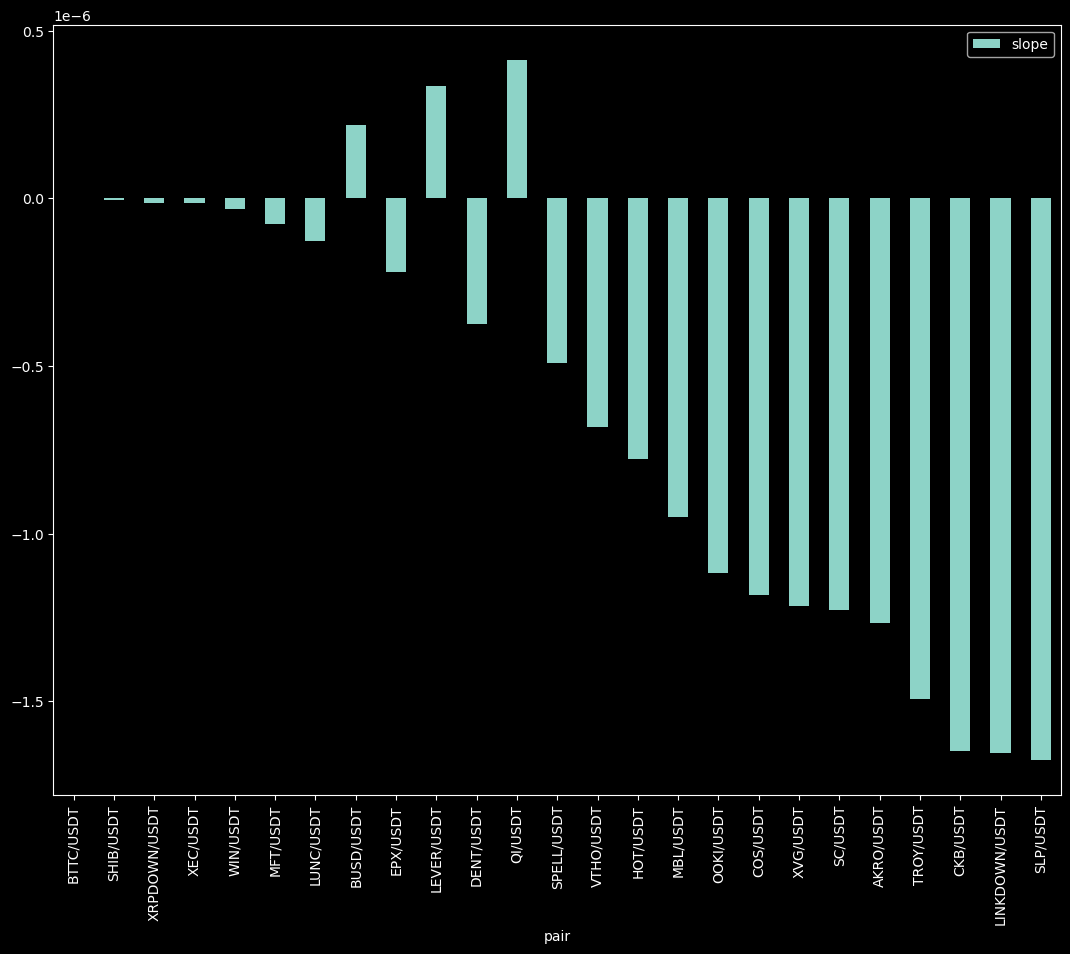

In [18]:
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (13, 10)
df.head(25).plot.bar(x='pair', y='slope')

In [19]:
def plot_market(df):
    plt.style.use('dark_background')
    plt.rcParams["figure.figsize"] = (13, 10)
    plt.plot(df.Close)

# Visualisation of the best markets

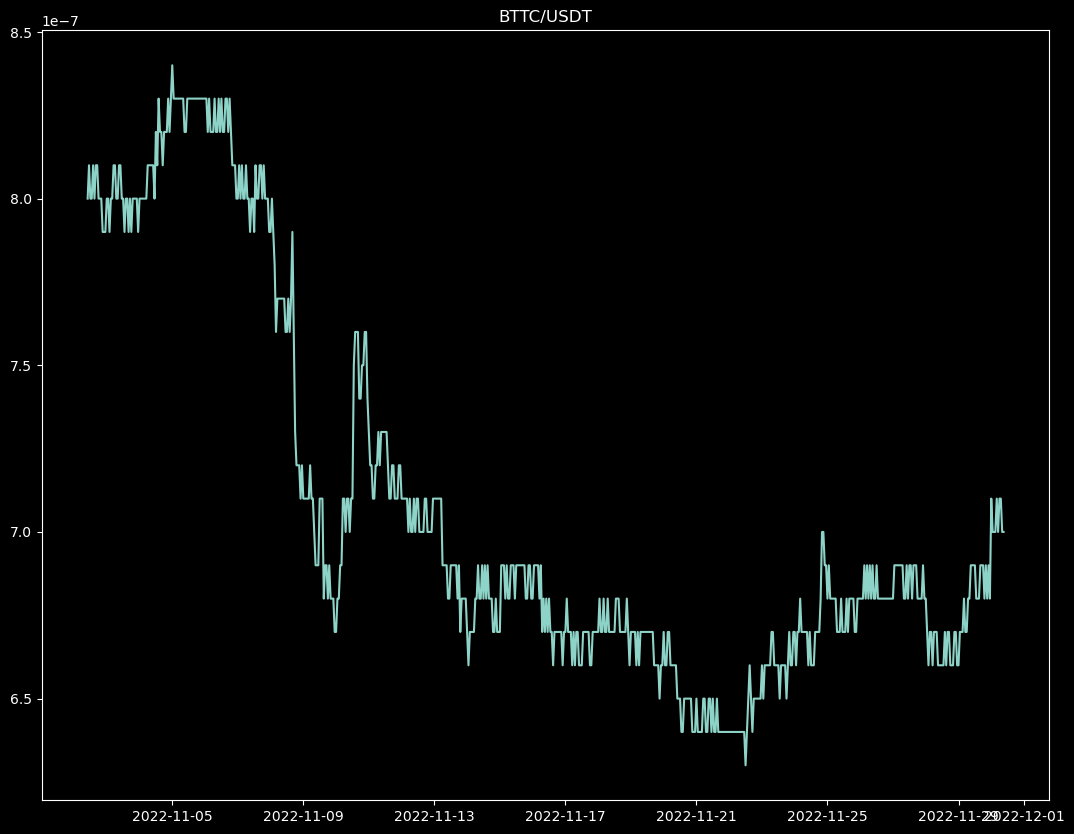

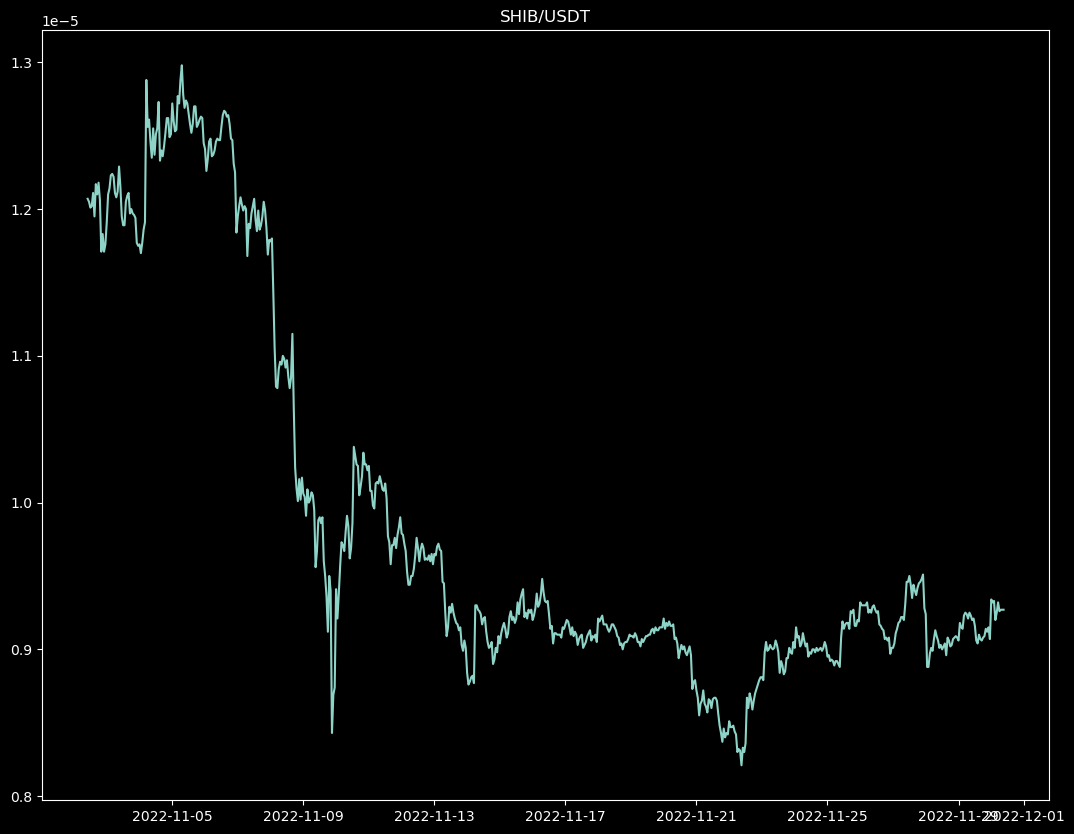

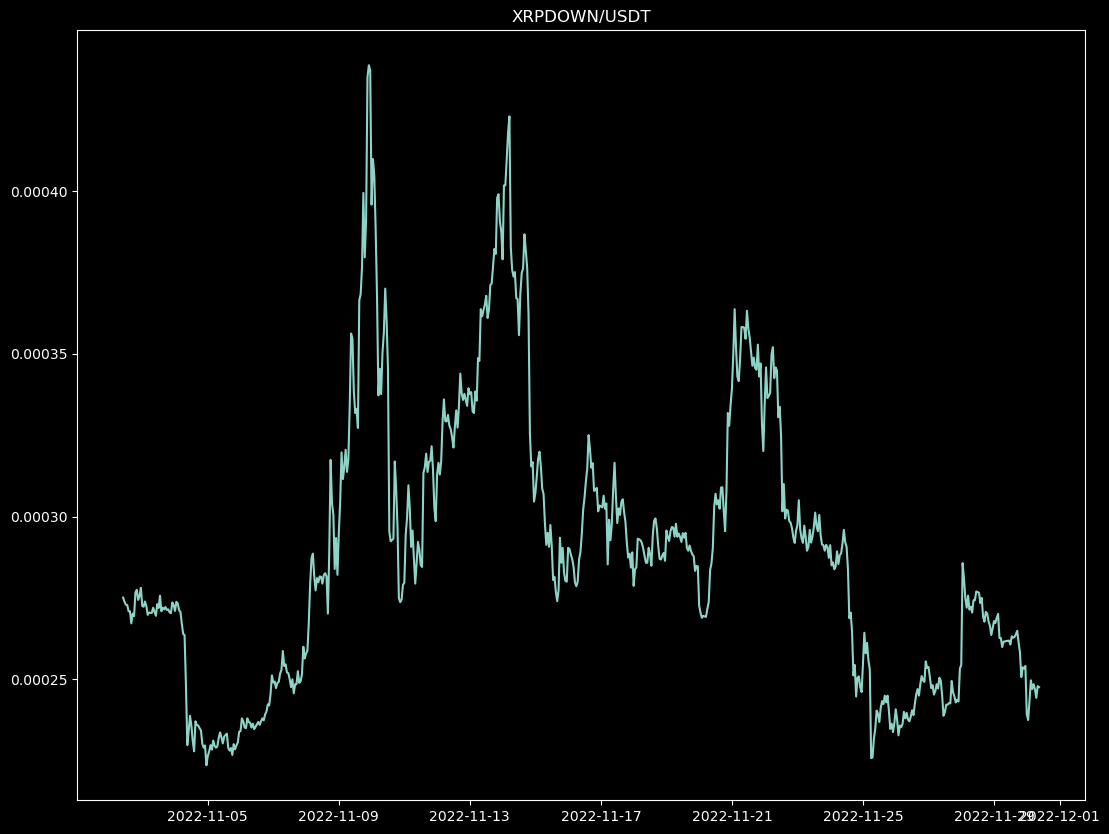

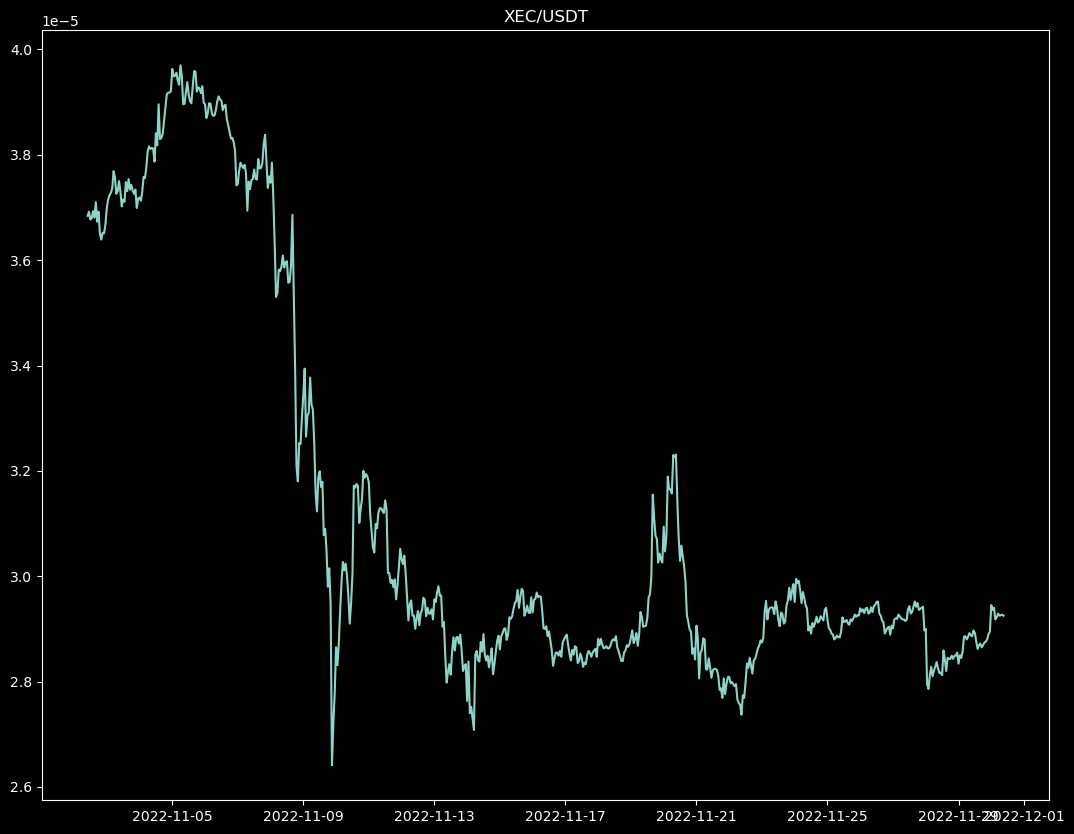

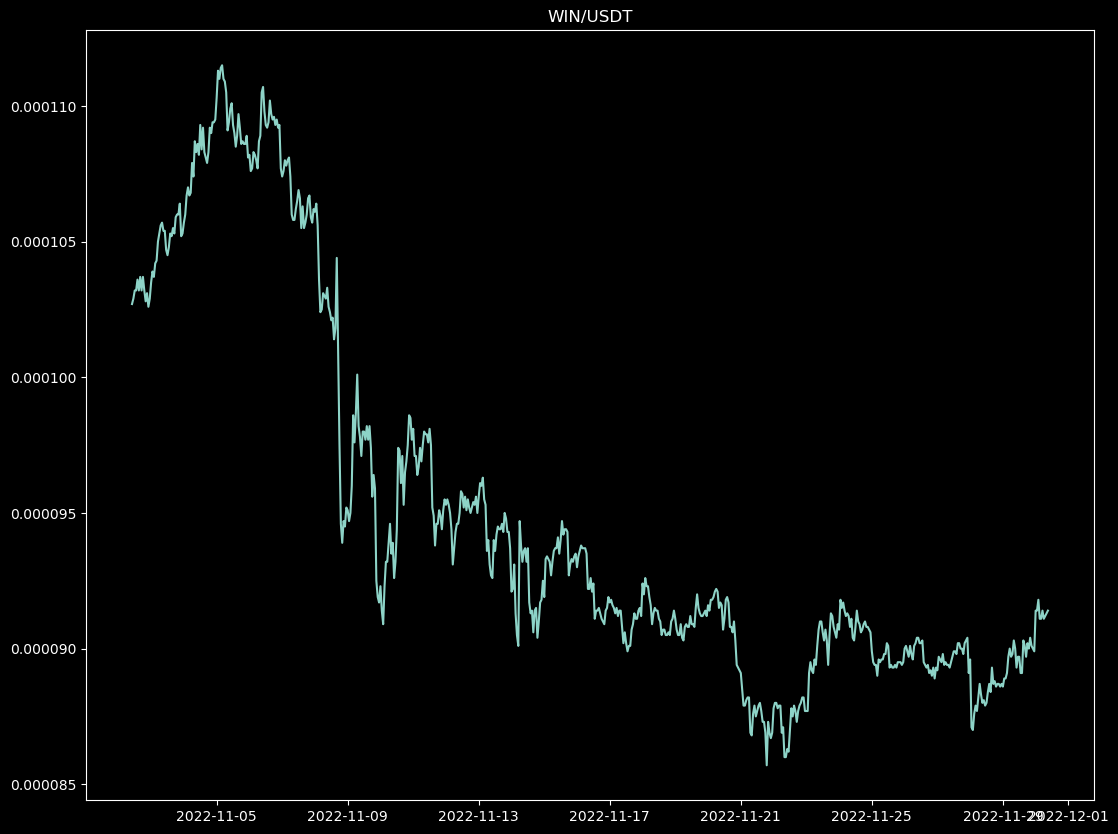

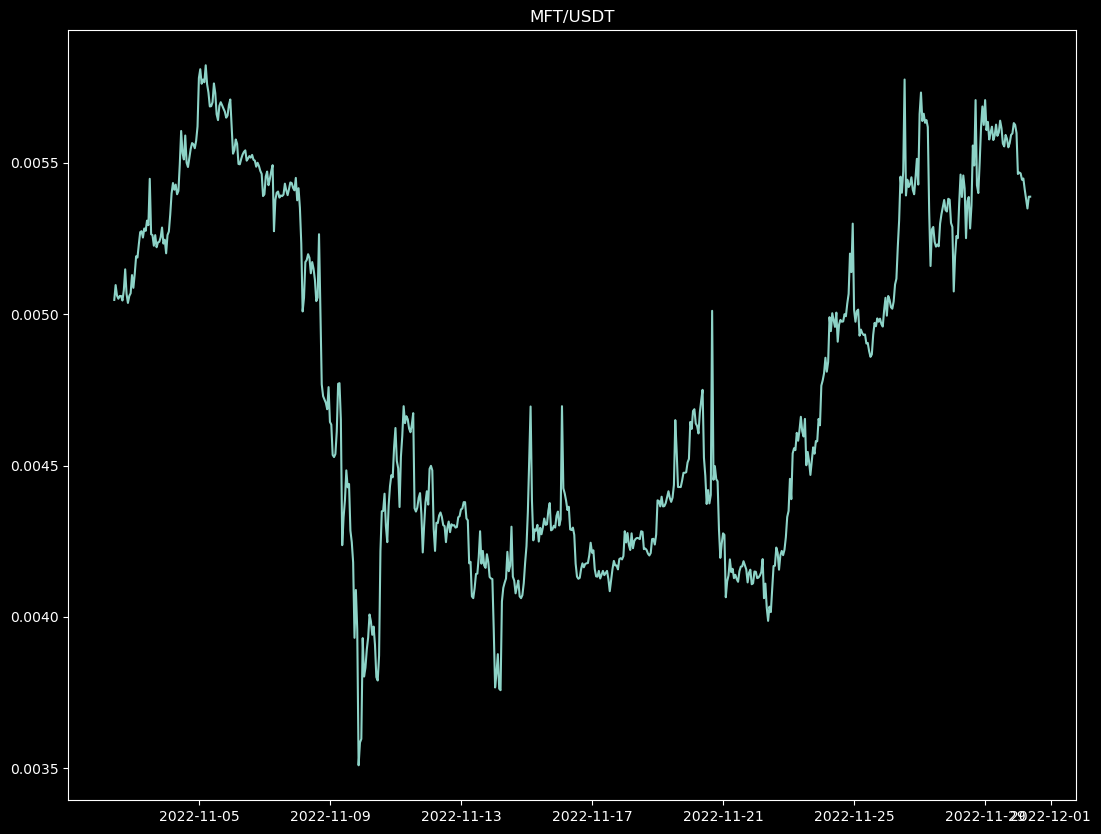

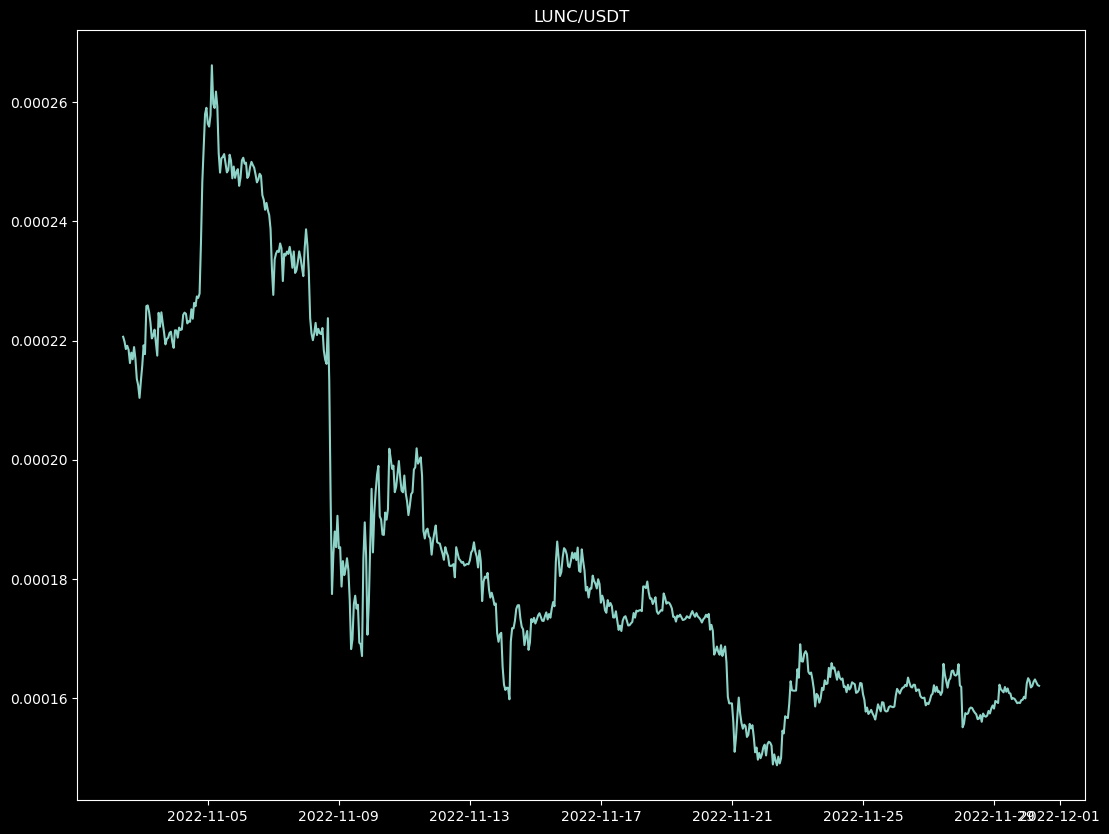

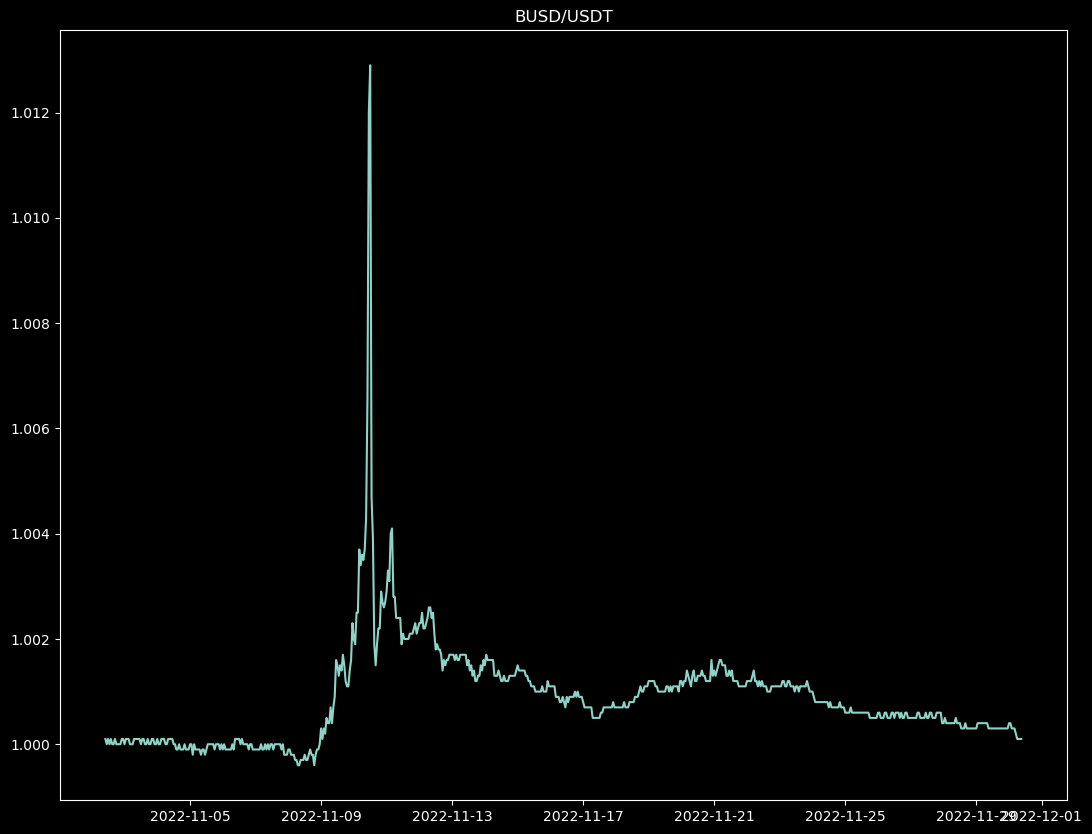

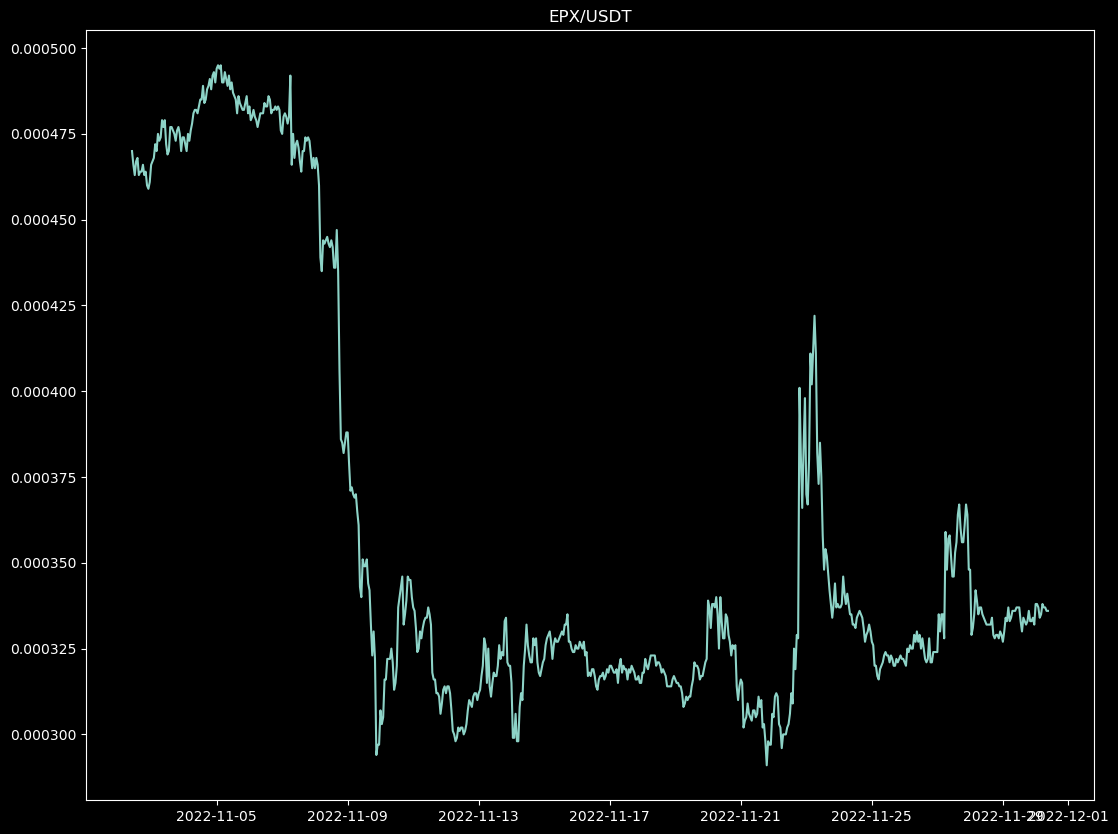

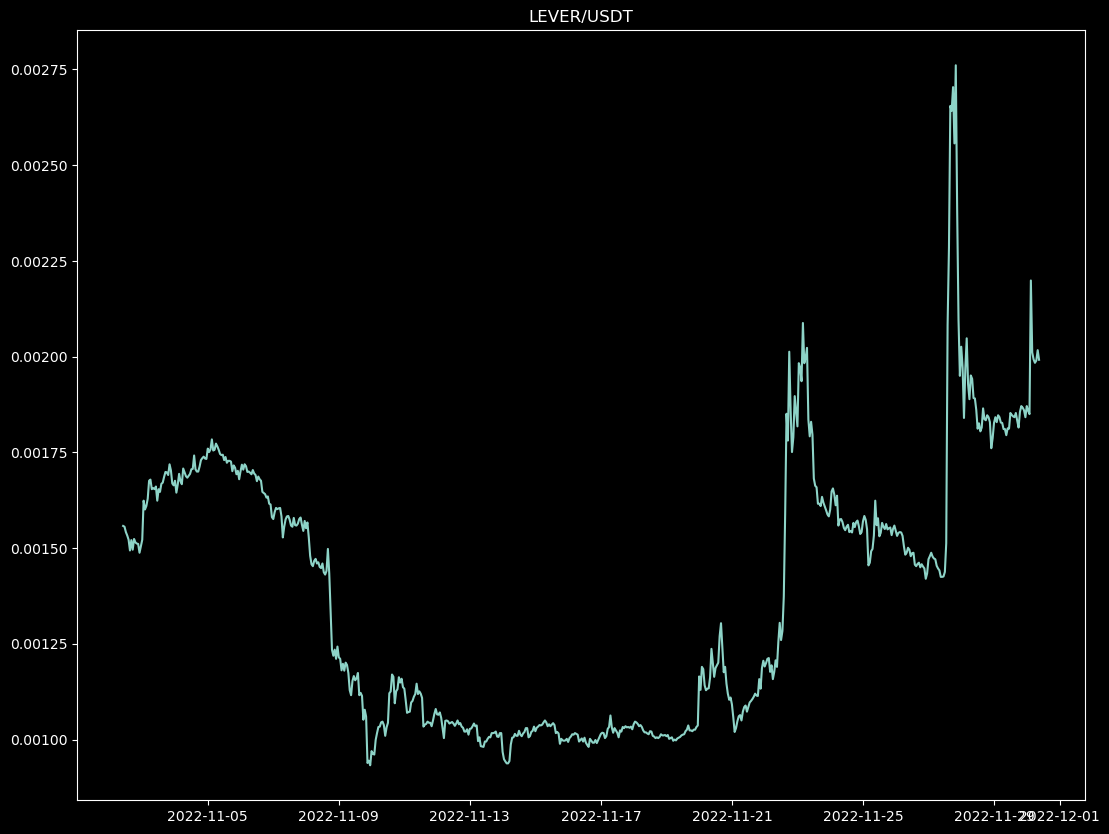

In [20]:
plt.rcParams["figure.figsize"] = (13, 10)

for index, row in df.head(10).iterrows():
#     print(row)
    ohlcv = get_all_ohlcv_for_pair(row['pair'], since=back_timestamp)
    if len(ohlcv) == 0:
        print('There is no quatation')
        continue
    df_ = make_data_frame(ohlcv)
    plt.plot(df_.Close)
    plt.style.use('dark_background')
    plt.title(row['pair'], fontsize=12)
    plt.show()